# import necessary package

In [47]:
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout
from keras.optimizers import SGD
import math
import matplotlib.pyplot as plt

# load monthly number of birth data

In [64]:
us_daily_birth_1 = pd.read_csv('./data/US_births_1994-2003_CDC_NCHS.csv')
us_daily_birth_2 = pd.read_csv('./data/US_births_2000-2014_SSA.csv')
us_daily_birth_1 = us_daily_birth_1.iloc[:2191,:]
us_daily_birth = pd.concat([us_daily_birth_1, us_daily_birth_2], axis=0)
us_daily_birth['DATE'] = pd.to_datetime(us_daily_birth['year'].astype(str) + '-' + us_daily_birth['month'].astype(str) + '-' + us_daily_birth['date_of_month'].astype(str))
us_daily_birth = us_daily_birth[['DATE', 'births']]

macro = pd.read_csv('./data/macro_monthly.csv')
macro = macro[['DATE','unrate','psr']]
macro['DATE'] = pd.to_datetime(macro['DATE'])

dd = pd.merge(us_daily_birth, macro, on="DATE")
dd.head()


,DATE,births,unrate,psr
0,1994-01-01,8096,6.6,7.1
1,1994-02-01,11755,6.6,6.5
2,1994-03-01,12127,6.5,6.8
3,1994-04-01,10630,6.4,6.4
4,1994-05-01,8145,6.1,7.6


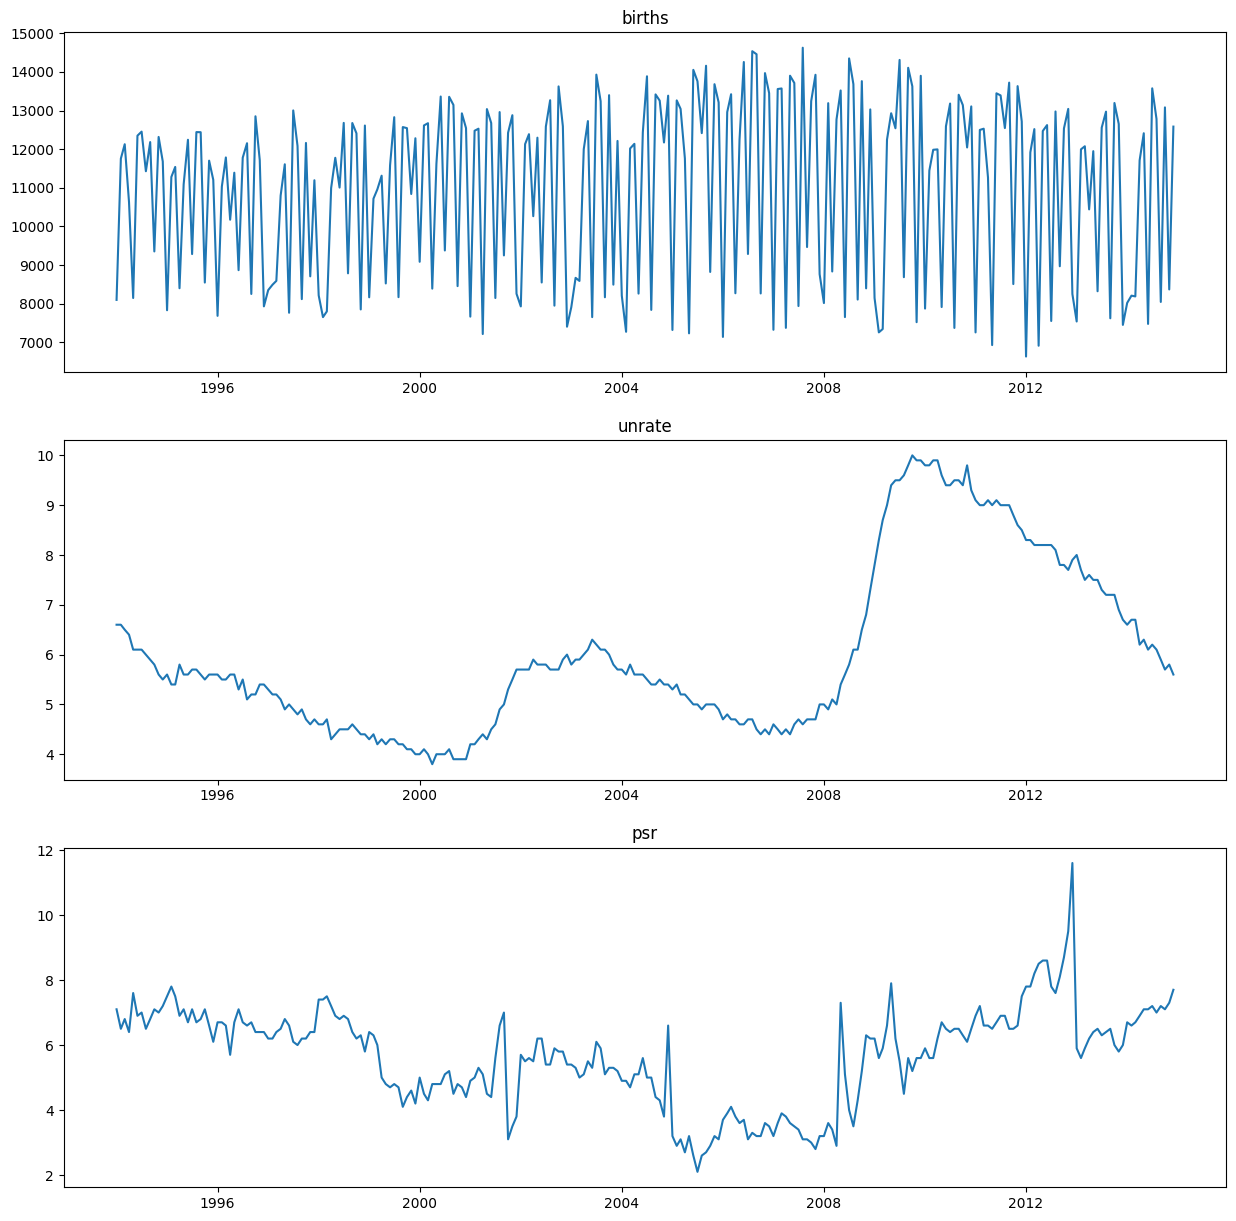

In [65]:
# plot birthsm, unrate, psr, in 3 subplots
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
ax[0].plot(dd['DATE'], dd['births'])
ax[0].set_title('births')
ax[1].plot(dd['DATE'], dd['unrate'])
ax[1].set_title('unrate')
ax[2].plot(dd['DATE'], dd['psr'])
ax[2].set_title('psr')
plt.show()


In [66]:
# set date as index
dd = dd.set_index('DATE')
dd.head()

,births,unrate,psr
DATE,,,
1994-01-01,8096,6.6,7.1
1994-02-01,11755,6.6,6.5
1994-03-01,12127,6.5,6.8
1994-04-01,10630,6.4,6.4
1994-05-01,8145,6.1,7.6


# build and train the RNN model without regularization

In [67]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dd)

# Define the train and test data
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size:, :]

# Define the time steps
time_steps = 12

# Define the train and test data with time steps
def create_dataset(data, time_steps):
    X, Y = [], []
    for i in range(len(data) - time_steps - 1):
        X.append(data[i:(i + time_steps), :])
        Y.append(data[(i + time_steps), 0])
    return np.array(X), np.array(Y)

trainX, trainY = create_dataset(train_data, time_steps)
testX, testY = create_dataset(test_data, time_steps)

In [68]:
# Define the model architecture
model = Sequential()
model.add(SimpleRNN(units=64, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(trainX, trainY, epochs=20, batch_size=64, validation_split=0.2, verbose=2)

Epoch 1/20
3/3 - 1s - loss: 0.1358 - val_loss: 0.1271 - 1s/epoch - 414ms/step
Epoch 2/20
3/3 - 0s - loss: 0.0947 - val_loss: 0.1236 - 48ms/epoch - 16ms/step
Epoch 3/20
3/3 - 0s - loss: 0.0662 - val_loss: 0.1209 - 43ms/epoch - 14ms/step
Epoch 4/20
3/3 - 0s - loss: 0.0609 - val_loss: 0.0961 - 63ms/epoch - 21ms/step
Epoch 5/20
3/3 - 0s - loss: 0.0522 - val_loss: 0.0942 - 40ms/epoch - 13ms/step
Epoch 6/20
3/3 - 0s - loss: 0.0500 - val_loss: 0.0974 - 41ms/epoch - 14ms/step
Epoch 7/20
3/3 - 0s - loss: 0.0468 - val_loss: 0.1109 - 64ms/epoch - 21ms/step
Epoch 8/20
3/3 - 0s - loss: 0.0467 - val_loss: 0.1050 - 101ms/epoch - 34ms/step
Epoch 9/20
3/3 - 0s - loss: 0.0441 - val_loss: 0.0987 - 270ms/epoch - 90ms/step
Epoch 10/20
3/3 - 0s - loss: 0.0452 - val_loss: 0.1004 - 145ms/epoch - 48ms/step
Epoch 11/20
3/3 - 0s - loss: 0.0407 - val_loss: 0.1094 - 74ms/epoch - 25ms/step
Epoch 12/20
3/3 - 0s - loss: 0.0418 - val_loss: 0.1105 - 53ms/epoch - 18ms/step
Epoch 13/20
3/3 - 0s - loss: 0.0401 - val_loss:

# plot the train and validation loss curve

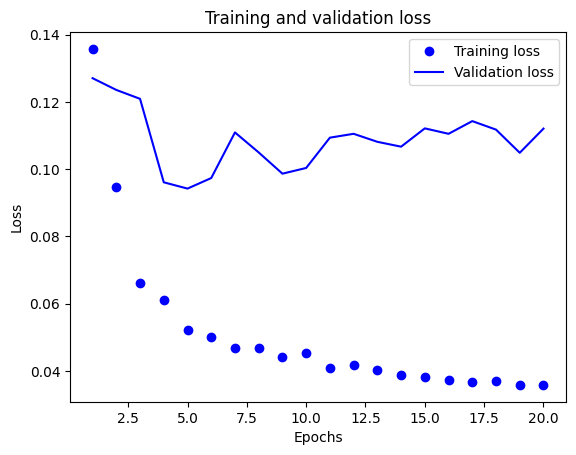

In [69]:
# plot train and validation loss
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# get th RMSE value for train and test data

In [70]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

rmse = np.sqrt(np.mean((trainY - trainPredict)**2))
print('Train RMSE: %.3f' % rmse)

rmse = np.sqrt(np.mean((testY - testPredict)**2))
print('Test RMSE: %.3f' % rmse)

2/2 [==============================] - 0s 7ms/step
Train RMSE: 0.366
Test RMSE: 0.385


# plot the result

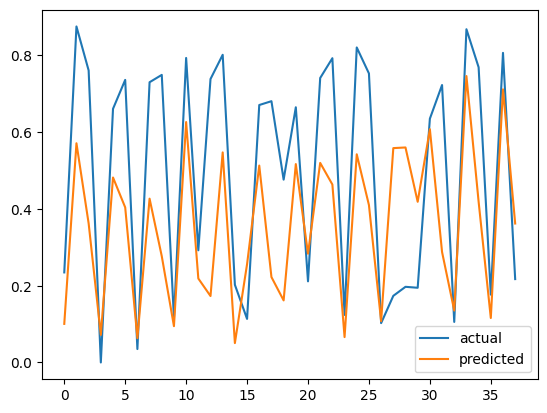

In [71]:
# Plot the results
import matplotlib.pyplot as plt
plt.plot(testY.flatten(), label='actual')
plt.plot(testPredict.flatten(), label='predicted')
plt.legend()
plt.show()

# build and train the RNN with regularization

In [72]:
# Define the model architecture
model = Sequential()
model.add(SimpleRNN(units=64, input_shape=(trainX.shape[1], trainX.shape[2])))
# add dropout
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(trainX, trainY, epochs=20, batch_size=64, validation_split=0.2, verbose=2)

Epoch 1/20
3/3 - 2s - loss: 0.1708 - val_loss: 0.1149 - 2s/epoch - 505ms/step
Epoch 2/20
3/3 - 0s - loss: 0.1517 - val_loss: 0.1250 - 60ms/epoch - 20ms/step
Epoch 3/20
3/3 - 0s - loss: 0.0949 - val_loss: 0.1484 - 71ms/epoch - 24ms/step
Epoch 4/20
3/3 - 0s - loss: 0.0673 - val_loss: 0.1386 - 54ms/epoch - 18ms/step
Epoch 5/20
3/3 - 0s - loss: 0.0793 - val_loss: 0.1295 - 53ms/epoch - 18ms/step
Epoch 6/20
3/3 - 0s - loss: 0.0717 - val_loss: 0.1077 - 84ms/epoch - 28ms/step
Epoch 7/20
3/3 - 0s - loss: 0.0641 - val_loss: 0.0946 - 65ms/epoch - 22ms/step
Epoch 8/20
3/3 - 0s - loss: 0.0632 - val_loss: 0.0927 - 42ms/epoch - 14ms/step
Epoch 9/20
3/3 - 0s - loss: 0.0636 - val_loss: 0.0957 - 60ms/epoch - 20ms/step
Epoch 10/20
3/3 - 0s - loss: 0.0547 - val_loss: 0.1002 - 42ms/epoch - 14ms/step
Epoch 11/20
3/3 - 0s - loss: 0.0614 - val_loss: 0.1021 - 40ms/epoch - 13ms/step
Epoch 12/20
3/3 - 0s - loss: 0.0584 - val_loss: 0.1095 - 38ms/epoch - 13ms/step
Epoch 13/20
3/3 - 0s - loss: 0.0550 - val_loss: 0.

# plot the train and validation loss curve

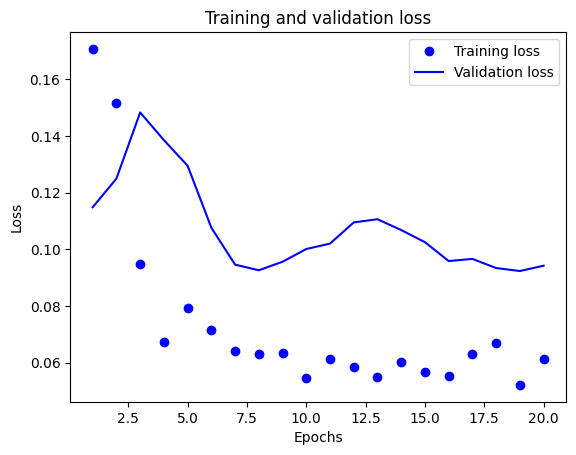

In [73]:
# plot train and validation loss
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# get the RMSE value for train and test data

In [74]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

rmse = np.sqrt(np.mean((trainY - trainPredict)**2))
print('Train RMSE: %.3f' % rmse)

rmse = np.sqrt(np.mean((testY - testPredict)**2))
print('Test RMSE: %.3f' % rmse)

2/2 [==============================] - 0s 6ms/step
Train RMSE: 0.359
Test RMSE: 0.353


# plot the result

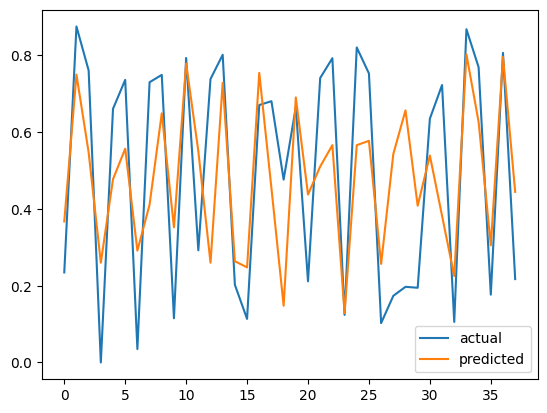

In [75]:
# Plot the results
import matplotlib.pyplot as plt
plt.plot(testY.flatten(), label='actual')
plt.plot(testPredict.flatten(), label='predicted')
plt.legend()
plt.show()

# build and train the LSTM without regularization

In [80]:
# Build the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# compile the lstm
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(trainX, trainY, epochs=20, batch_size=64, validation_split=0.2, verbose=2)

Epoch 1/20
3/3 - 5s - loss: 0.3973 - val_loss: 0.2746 - 5s/epoch - 2s/step
Epoch 2/20
3/3 - 0s - loss: 0.2225 - val_loss: 0.1509 - 89ms/epoch - 30ms/step
Epoch 3/20
3/3 - 0s - loss: 0.1138 - val_loss: 0.1347 - 82ms/epoch - 27ms/step
Epoch 4/20
3/3 - 0s - loss: 0.0898 - val_loss: 0.2060 - 79ms/epoch - 26ms/step
Epoch 5/20
3/3 - 0s - loss: 0.1131 - val_loss: 0.1786 - 98ms/epoch - 33ms/step
Epoch 6/20
3/3 - 0s - loss: 0.0954 - val_loss: 0.1327 - 159ms/epoch - 53ms/step
Epoch 7/20
3/3 - 0s - loss: 0.0823 - val_loss: 0.1193 - 140ms/epoch - 47ms/step
Epoch 8/20
3/3 - 0s - loss: 0.0825 - val_loss: 0.1175 - 105ms/epoch - 35ms/step
Epoch 9/20
3/3 - 0s - loss: 0.0843 - val_loss: 0.1165 - 104ms/epoch - 35ms/step
Epoch 10/20
3/3 - 0s - loss: 0.0831 - val_loss: 0.1156 - 106ms/epoch - 35ms/step
Epoch 11/20
3/3 - 0s - loss: 0.0799 - val_loss: 0.1163 - 80ms/epoch - 27ms/step
Epoch 12/20
3/3 - 0s - loss: 0.0783 - val_loss: 0.1192 - 89ms/epoch - 30ms/step
Epoch 13/20
3/3 - 0s - loss: 0.0775 - val_loss: 

# plot the train and validation loss curve

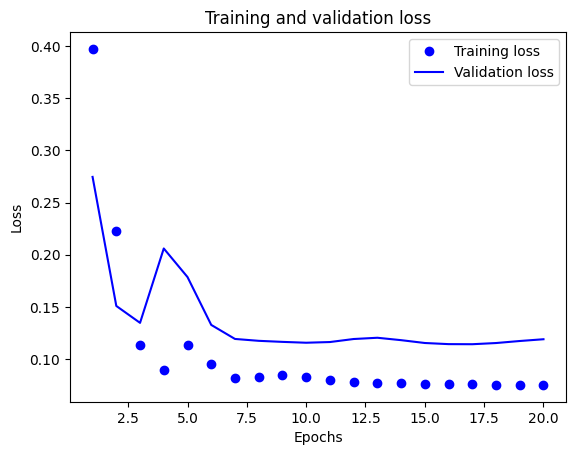

In [81]:
# plot train and validation loss
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# get the RMSE value for train and test data

In [82]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

rmse = np.sqrt(np.mean((trainY - trainPredict)**2))
print('Train RMSE: %.3f' % rmse)

rmse = np.sqrt(np.mean((testY - testPredict)**2))
print('Test RMSE: %.3f' % rmse)

2/2 [==============================] - 0s 4ms/step
Train RMSE: 0.302
Test RMSE: 0.310


# plot the result

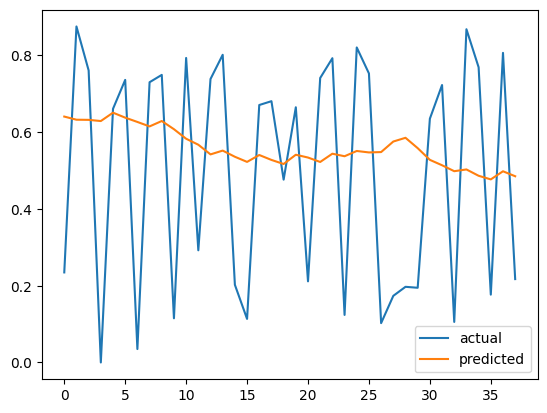

In [83]:
# Plot the results
import matplotlib.pyplot as plt
plt.plot(testY.flatten(), label='actual')
plt.plot(testPredict.flatten(), label='predicted')
plt.legend()
plt.show()

# build and train the LSTM with regularization

In [84]:
# Build the model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# compile the lstm
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(trainX, trainY, epochs=20, batch_size=64, validation_split=0.2, verbose=2)

Epoch 1/20
3/3 - 6s - loss: 0.2247 - val_loss: 0.1580 - 6s/epoch - 2s/step
Epoch 2/20
3/3 - 0s - loss: 0.1174 - val_loss: 0.1180 - 90ms/epoch - 30ms/step
Epoch 3/20
3/3 - 0s - loss: 0.0905 - val_loss: 0.1405 - 103ms/epoch - 34ms/step
Epoch 4/20
3/3 - 0s - loss: 0.0995 - val_loss: 0.1212 - 97ms/epoch - 32ms/step
Epoch 5/20
3/3 - 0s - loss: 0.0863 - val_loss: 0.1147 - 139ms/epoch - 46ms/step
Epoch 6/20
3/3 - 0s - loss: 0.0843 - val_loss: 0.1186 - 118ms/epoch - 39ms/step
Epoch 7/20
3/3 - 0s - loss: 0.0878 - val_loss: 0.1183 - 121ms/epoch - 40ms/step
Epoch 8/20
3/3 - 0s - loss: 0.0901 - val_loss: 0.1150 - 230ms/epoch - 77ms/step
Epoch 9/20
3/3 - 0s - loss: 0.0828 - val_loss: 0.1142 - 133ms/epoch - 44ms/step
Epoch 10/20
3/3 - 0s - loss: 0.0786 - val_loss: 0.1179 - 87ms/epoch - 29ms/step
Epoch 11/20
3/3 - 0s - loss: 0.0846 - val_loss: 0.1156 - 68ms/epoch - 23ms/step
Epoch 12/20
3/3 - 0s - loss: 0.0730 - val_loss: 0.1140 - 121ms/epoch - 40ms/step
Epoch 13/20
3/3 - 0s - loss: 0.0770 - val_loss

# plot the train and validation loss curve

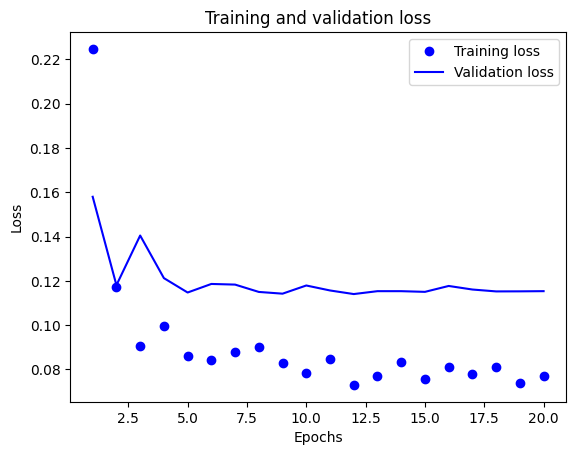

In [85]:
# plot train and validation loss
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# get the RMSE value for train and test data

In [86]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

rmse = np.sqrt(np.mean((trainY - trainPredict)**2))
print('Train RMSE: %.3f' % rmse)

rmse = np.sqrt(np.mean((testY - testPredict)**2))
print('Test RMSE: %.3f' % rmse)

2/2 [==============================] - 0s 6ms/step
Train RMSE: 0.299
Test RMSE: 0.301


# plot the result

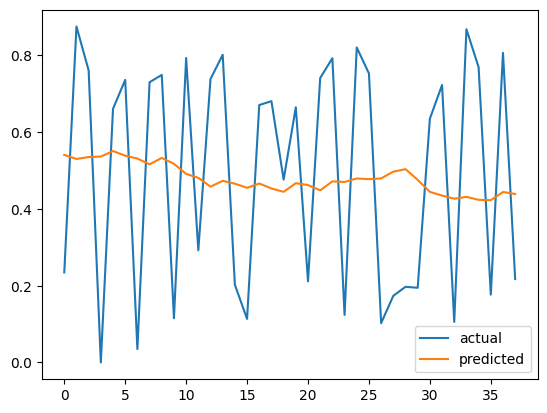

In [87]:
# Plot the results
import matplotlib.pyplot as plt
plt.plot(testY.flatten(), label='actual')
plt.plot(testPredict.flatten(), label='predicted')
plt.legend()
plt.show()

# build and train the GRU without regularization

In [88]:
# Define the model architecture
model = Sequential()
model.add(GRU(units=64, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(trainX, trainY, epochs=20, batch_size=64, validation_split=0.2, verbose=2)

Epoch 1/20
3/3 - 6s - loss: 0.5564 - val_loss: 0.4589 - 6s/epoch - 2s/step
Epoch 2/20
3/3 - 0s - loss: 0.3771 - val_loss: 0.2960 - 50ms/epoch - 17ms/step
Epoch 3/20
3/3 - 0s - loss: 0.2403 - val_loss: 0.1855 - 50ms/epoch - 17ms/step
Epoch 4/20
3/3 - 0s - loss: 0.1526 - val_loss: 0.1305 - 47ms/epoch - 16ms/step
Epoch 5/20
3/3 - 0s - loss: 0.1050 - val_loss: 0.1289 - 48ms/epoch - 16ms/step
Epoch 6/20
3/3 - 0s - loss: 0.1024 - val_loss: 0.1488 - 46ms/epoch - 15ms/step
Epoch 7/20
3/3 - 0s - loss: 0.1106 - val_loss: 0.1500 - 45ms/epoch - 15ms/step
Epoch 8/20
3/3 - 0s - loss: 0.1085 - val_loss: 0.1360 - 47ms/epoch - 16ms/step
Epoch 9/20
3/3 - 0s - loss: 0.0984 - val_loss: 0.1219 - 46ms/epoch - 15ms/step
Epoch 10/20
3/3 - 0s - loss: 0.0899 - val_loss: 0.1140 - 56ms/epoch - 19ms/step
Epoch 11/20
3/3 - 0s - loss: 0.0855 - val_loss: 0.1113 - 86ms/epoch - 29ms/step
Epoch 12/20
3/3 - 0s - loss: 0.0860 - val_loss: 0.1109 - 100ms/epoch - 33ms/step
Epoch 13/20
3/3 - 0s - loss: 0.0858 - val_loss: 0.11

# plot the train and validation loss curve

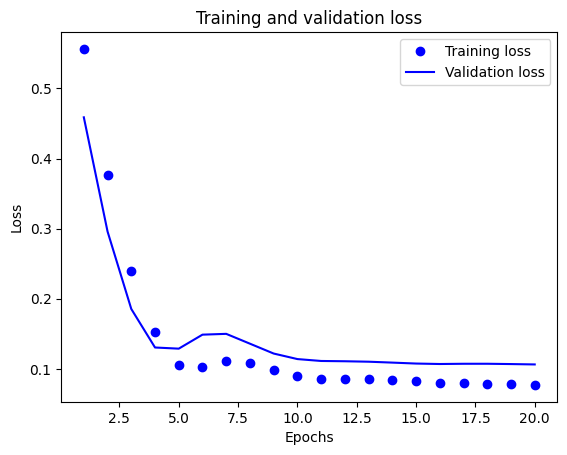

In [89]:
# plot train and validation loss
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# get the RMSE value for train and test data

In [90]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

rmse = np.sqrt(np.mean((trainY - trainPredict)**2))
print('Train RMSE: %.3f' % rmse)

rmse = np.sqrt(np.mean((testY - testPredict)**2))
print('Test RMSE: %.3f' % rmse)

2/2 [==============================] - 0s 5ms/step
Train RMSE: 0.299
Test RMSE: 0.331


# plot the result

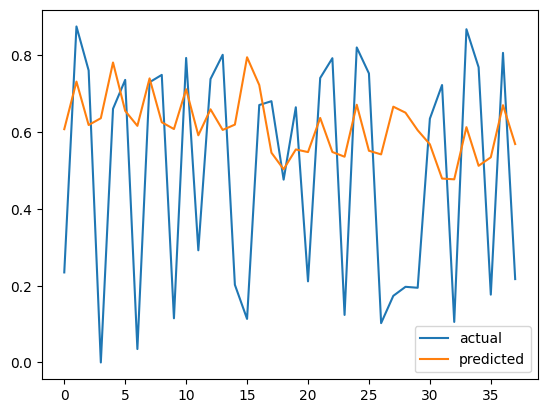

In [91]:
# Plot the results
import matplotlib.pyplot as plt
plt.plot(testY.flatten(), label='actual')
plt.plot(testPredict.flatten(), label='predicted')
plt.legend()
plt.show()

# build and train the GRU without regularization

In [92]:
# Define the model architecture
model = Sequential()
model.add(GRU(units=64, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history = model.fit(trainX, trainY, epochs=20, batch_size=64, validation_split=0.2, verbose=2)

Epoch 1/20
3/3 - 3s - loss: 0.1868 - val_loss: 0.2167 - 3s/epoch - 1s/step
Epoch 2/20
3/3 - 0s - loss: 0.1182 - val_loss: 0.1496 - 66ms/epoch - 22ms/step
Epoch 3/20
3/3 - 0s - loss: 0.0946 - val_loss: 0.1293 - 81ms/epoch - 27ms/step
Epoch 4/20
3/3 - 0s - loss: 0.0971 - val_loss: 0.1301 - 70ms/epoch - 23ms/step
Epoch 5/20
3/3 - 0s - loss: 0.1065 - val_loss: 0.1282 - 69ms/epoch - 23ms/step
Epoch 6/20
3/3 - 0s - loss: 0.1007 - val_loss: 0.1293 - 267ms/epoch - 89ms/step
Epoch 7/20
3/3 - 0s - loss: 0.0854 - val_loss: 0.1361 - 74ms/epoch - 25ms/step
Epoch 8/20
3/3 - 0s - loss: 0.0884 - val_loss: 0.1417 - 189ms/epoch - 63ms/step
Epoch 9/20
3/3 - 0s - loss: 0.0932 - val_loss: 0.1431 - 124ms/epoch - 41ms/step
Epoch 10/20
3/3 - 0s - loss: 0.0911 - val_loss: 0.1372 - 93ms/epoch - 31ms/step
Epoch 11/20
3/3 - 0s - loss: 0.0913 - val_loss: 0.1304 - 84ms/epoch - 28ms/step
Epoch 12/20
3/3 - 0s - loss: 0.0911 - val_loss: 0.1252 - 70ms/epoch - 23ms/step
Epoch 13/20
3/3 - 0s - loss: 0.0898 - val_loss: 0.

# plot the train and validation loss curve

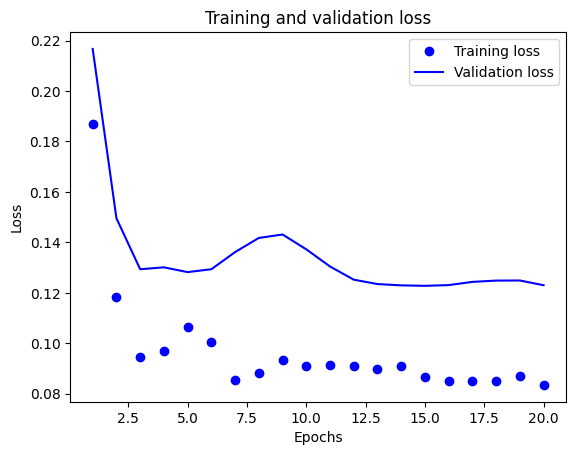

In [93]:
# plot train and validation loss
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# get the RMSE value for train and test data

In [94]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

rmse = np.sqrt(np.mean((trainY - trainPredict)**2))
print('Train RMSE: %.3f' % rmse)

rmse = np.sqrt(np.mean((testY - testPredict)**2))
print('Test RMSE: %.3f' % rmse)

2/2 [==============================] - 0s 8ms/step
Train RMSE: 0.299
Test RMSE: 0.302


# plot the result

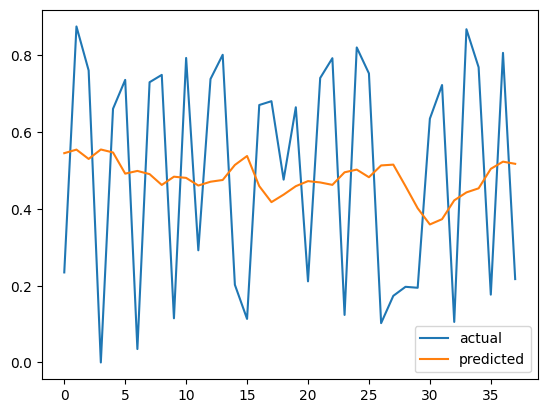

In [95]:
# Plot the results
import matplotlib.pyplot as plt
plt.plot(testY.flatten(), label='actual')
plt.plot(testPredict.flatten(), label='predicted')
plt.legend()
plt.show()